## Things to do:
- figure out how to improve the results


#### Importing necessary packages

In [17]:
!pip install --upgrade git+https://github.com/bes-dev/mean_average_precision.git

# import necessary packages
import numpy as np
import pandas as pd 
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches
from zipfile import ZipFile 
from io import BytesIO
from mean_average_precision import MetricBuilder
from google.colab import drive
drive.mount('/content/drive')


import sys
sys.path.append('/content/drive/MyDrive/my_projects/helpers/pytorch')

from engine import train_one_epoch, evaluate
import utils

# setting the device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

  Cloning https://github.com/bes-dev/mean_average_precision.git to /tmp/pip-req-build-qjyd62_8
  Running command git clone -q https://github.com/bes-dev/mean_average_precision.git /tmp/pip-req-build-qjyd62_8
  Created wheel for mean-average-precision: filename=mean_average_precision-0.0.2.1-cp36-none-any.whl size=14137 sha256=925c50ecd2f7833751f455264035ec7d0f3b3c6f5c081b734c16710c02cd967f
  Stored in directory: /tmp/pip-ephem-wheel-cache-t87l6217/wheels/49/90/b8/9264e51137d158d3f37cb48e08092ab8d020c7a9349eaa9ec2
Successfully built mean-average-precision
  Found existing installation: mean-average-precision 0.0.2.1
    Uninstalling mean-average-precision-0.0.2.1:
      Successfully uninstalled mean-average-precision-0.0.2.1


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Helper functions to create bounding-boxes & target labels

In [2]:
def generate_box(obj):
  """helper function to generate the bounding box"""

  xmin = int(obj.find('xmin').text)
  ymin = int(obj.find('ymin').text)
  xmax = int(obj.find('xmax').text)
  ymax = int(obj.find('ymax').text)

  return [xmin, ymin, xmax, ymax]


def generate_label(obj):
  """helper function to generate the label of the object"""

  if obj.find('name').text == "with_mask":
      return 2
  elif obj.find('name').text == "mask_weared_incorrect":
      return 3
  else:
    return 1


def generate_target(image_id, file): 
  """helper function to generate the target label(s) for a training instance"""
  
  soup = BeautifulSoup(file, 'xml')
  objects = soup.find_all('object')

  num_objs = len(objects)

  # Bounding boxes for objects
  # In coco format, bbox = [xmin, ymin, width, height]
  # In pytorch, the input should be [xmin, ymin, xmax, ymax]
  boxes = []
  labels = []

  for i in objects:
      boxes.append(generate_box(i))
      labels.append(generate_label(i))

  boxes = torch.as_tensor(boxes, dtype=torch.float32)

  # Labels (In my case, I only one class: target class or background)
  labels = torch.as_tensor(labels, dtype=torch.int64)

  # Tensorise img_id
  img_id = torch.tensor([image_id])

  # Annotation is in dictionary format
  target = {}
  target["boxes"] = boxes
  target["labels"] = labels
  target["image_id"] = img_id

  return target


#### Defining Dataset

In [3]:
class MaskDataset(object):

    def __init__(self, transforms, dataset_type):

        self.transforms   = transforms
        self.dataset_type = dataset_type

        data_split_info = pd.read_csv('/content/drive/MyDrive/my_projects/datasets/mask_data/DatasetSplit.csv')
        data_split_info.set_index('Unnamed: 0',inplace=True)
        data_split_info.loc['img train:'].values

        if self.dataset_type == 'train':
          img_file_names = data_split_info.loc['img train:'].values[0]
          annotation_file_names = data_split_info.loc['xml train:'].values[0]

          img_file_names = img_file_names.replace('[','')
          img_file_names = img_file_names.replace(']','')
          img_file_names = img_file_names.split(',')
          img_file_names = [item[1:-1] for item in img_file_names]

          annotation_file_names = annotation_file_names.replace('[','')
          annotation_file_names = annotation_file_names.replace(']','')
          annotation_file_names = annotation_file_names.split(',')
          annotation_file_names = [item[1:-1] for item in annotation_file_names]

        elif self.dataset_type == 'test':
          img_file_names = data_split_info.loc['img test:'].values[0]
          annotation_file_names = data_split_info.loc['xml test:'].values[0]  

          img_file_names = img_file_names.replace('[','')
          img_file_names = img_file_names.replace(']','')
          img_file_names = img_file_names.split(',')
          img_file_names = [item[1:-1] for item in img_file_names]

          annotation_file_names = annotation_file_names.replace('[','')
          annotation_file_names = annotation_file_names.replace(']','')
          annotation_file_names = annotation_file_names.split(',')
          annotation_file_names = [item[1:-1] for item in annotation_file_names]

        elif self.dataset_type == 'validation':
          img_file_names = data_split_info.loc['img validation:'].values[0]
          annotation_file_names = data_split_info.loc['xml validation:'].values[0] 

          img_file_names = img_file_names.replace('[','')
          img_file_names = img_file_names.replace(']','')
          img_file_names = img_file_names.split(',')
          img_file_names = [item[1:-1] for item in img_file_names]

          annotation_file_names = annotation_file_names.replace('[','')
          annotation_file_names = annotation_file_names.replace(']','')
          annotation_file_names = annotation_file_names.split(',')
          annotation_file_names = [item[1:-1] for item in annotation_file_names]

        else: 
          # load all image files, sorting them to ensure that they are aligned
          with ZipFile('/content/drive/MyDrive/my_projects/datasets/mask_data/dataset.zip','r') as zipp:
            all_zip_file_info = zipp.filelist
          
          file_names = []
          for zip_file_info in all_zip_file_info:
            file_names.append(zip_file_info.orig_filename)
            
          img_file_names = [file_name[7:] for file_name in file_names if "images" in file_name]
          annotation_file_names = [file_name[12:] for file_name in file_names if "annotations" in file_name]

        self.imgs = list(sorted(img_file_names))
        self.labels = list(sorted(annotation_file_names))
        
        self.zipp = ZipFile('/content/drive/MyDrive/my_projects/datasets/mask_data/dataset.zip','r')

    def __getitem__(self, idx):

      # load images and masks
      file_image = 'maksssksksss'+ str(idx) + '.png'
      file_label = 'maksssksksss'+ str(idx) + '.xml'


      img_raw = self.zipp.read('images/'+ file_image)
      fh = BytesIO(img_raw)
      img = Image.open(fh).convert("RGB")

      #Generate Label
      label_file = self.zipp.read('annotations/'+ file_label)
      target = generate_target(idx, label_file)

      if self.transforms is not None:
          img = self.transforms(img)

      return img, target

    def __len__(self):
      return len(self.imgs)

### Iteration 1

#### Defining transformations

In [4]:
def get_transform():
    transf = []
    transf.append(transforms.ToTensor())
        
    return transforms.Compose(transf)

#### Creating train, test and validation Datasets & Data-loaders

In [5]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset_train = MaskDataset(get_transform(),'train')
data_loader_train = torch.utils.data.DataLoader(dataset_train
                                               , batch_size=4
                                               , collate_fn=collate_fn
                                                )

dataset_test = MaskDataset(get_transform(),'test')
data_loader_test = torch.utils.data.DataLoader(dataset_test
                                               , batch_size=4
                                               , collate_fn=collate_fn
                                               )

# dataset_val = MaskDataset(get_transform(),'validation')
# data_loader_val = torch.utils.data.DataLoader(dataset_val
#                                                , batch_size=4
#                                                , collate_fn=collate_fn
#                                               )

#### Initializing the Model

In [6]:
def get_model_instance_segmentation(num_classes):

    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes+1)

    return model

In [7]:
model = get_model_instance_segmentation(3)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


#### Training the Model

In [8]:
num_epochs = 30
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params
                            , lr=0.005
                            , momentum=0.9
                            , weight_decay=0.0005)


len_dataloader = len(data_loader_train)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader_train:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
    print(epoch_loss)

tensor(91.3231, device='cuda:0', grad_fn=<AddBackward0>)
tensor(58.8527, device='cuda:0', grad_fn=<AddBackward0>)
tensor(53.2007, device='cuda:0', grad_fn=<AddBackward0>)
tensor(44.6149, device='cuda:0', grad_fn=<AddBackward0>)
tensor(36.3864, device='cuda:0', grad_fn=<AddBackward0>)
tensor(33.1807, device='cuda:0', grad_fn=<AddBackward0>)
tensor(30.9123, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.1342, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.1815, device='cuda:0', grad_fn=<AddBackward0>)
tensor(26.7716, device='cuda:0', grad_fn=<AddBackward0>)
tensor(24.8442, device='cuda:0', grad_fn=<AddBackward0>)
tensor(25.7469, device='cuda:0', grad_fn=<AddBackward0>)
tensor(26.4326, device='cuda:0', grad_fn=<AddBackward0>)
tensor(24.5147, device='cuda:0', grad_fn=<AddBackward0>)
tensor(22.7686, device='cuda:0', grad_fn=<AddBackward0>)
tensor(22.9110, device='cuda:0', grad_fn=<AddBackward0>)
tensor(19.3999, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.7586, device='cuda:0'

#### Saving the model

In [9]:
# save model
torch.save(model.state_dict(),'/content/drive/MyDrive/my_projects/models/fasterr_cnn_mod_1.pt')
model.load_state_dict(torch.load('/content/drive/MyDrive/my_projects/models/fasterr_cnn_mod_1.pt'))

<All keys matched successfully>

#### Making Model Predictions for a sampled data batch from Test Data-Loader

In [10]:
for imgs, annotations in data_loader_test:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    break


model.eval()
model.to(device)
preds = model(imgs)

#### Defining a function to plot images

In [11]:
def plot_image(img_tensor, annotation, block=True):
  """ function to show both with-mask and without-mask instances"""

  fig,ax = plt.subplots(1)
  img = img_tensor.cpu().data

  # Display the image
  ax.imshow( np.array( img.permute(1, 2, 0) ) )

  for box, label in zip( annotation["boxes"], annotation["labels"] ):
    #print("label",label)
    #print("box",box)
    xmin, ymin, xmax, ymax = box
    
    # Create a Rectangle patch
    if label==1:
      rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='b',facecolor='none')
    else:
      rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    ax.axis("off")
  
  plt.show(block=block)

#### Plotting the prediction


 Prediction: 


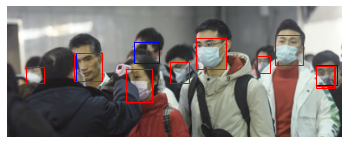


 Target: 


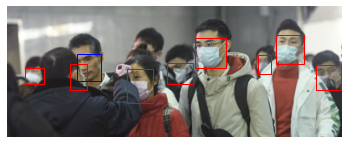

In [12]:
print("\n Prediction: ")
plot_image(imgs[1], preds[1])
print("\n Target: ")
plot_image(imgs[1], annotations[1])

#### Computing mAP of the model for the Test set

In [13]:
# create metric_fn
metric_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True, num_classes=3)

for imgs, annos in data_loader_test:

    imgs = list(img.to(device) for img in imgs)
    preds_batch = model(imgs)
    anno_batch = [{k: v.to(device) for k, v in t.items()} for t in annos]
    
    for preds, annotations in zip(preds_batch, anno_batch):
      if preds['boxes'].shape[0] > 0:
        temp_preds = torch.cat((preds['boxes'].T,preds['labels'].reshape(-1,preds['labels'].shape[0]),preds['scores'].reshape(-1,preds['scores'].shape[0])),0).T.detach().cpu().numpy()
      else:
        temp_preds = np.zeros((preds['boxes'].shape[1],6)) # in case if no prediction is made - make a random prediction
        
      temp_annotations = torch.cat((annotations['boxes'].T,annotations['labels'].reshape(-1,annotations['labels'].shape[0])),0).T.detach().cpu().numpy()
      temp_target = np.hstack((temp_annotations,np.zeros((temp_annotations.shape[0],2))))

      metric_fn.add(temp_preds, temp_target)

In [14]:
# compute PASCAL VOC metric
print(f"VOC PASCAL mAP: {metric_fn.value(iou_thresholds=0.5, recall_thresholds=np.arange(0., 1.1, 0.1))['mAP']}")

# compute PASCAL VOC metric at the all points
print(f"VOC PASCAL mAP in all points: {metric_fn.value(iou_thresholds=0.5)['mAP']}")

# compute metric COCO metric
print(f"COCO mAP: {metric_fn.value(iou_thresholds=np.arange(0.5, 1.0, 0.05), recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy='soft')['mAP']}")

del (data_loader_test,data_loader_train,dataset_test,dataset_train,model)
torch.cuda.empty_cache()

VOC PASCAL mAP: 0.5984109044075012
VOC PASCAL mAP in all points: 0.6239367127418518
COCO mAP: 0.4374750256538391


### Iteration 2: Tuning further for higher mAP

- Apply transformations
- Use learning rate finder

#### Define new model and transform function

In [15]:
class MaskDataset(object):

    def __init__(self, transforms, dataset_type):

        self.transforms   = transforms
        self.dataset_type = dataset_type

        data_split_info = pd.read_csv('/content/drive/MyDrive/my_projects/datasets/mask_data/DatasetSplit.csv')
        data_split_info.set_index('Unnamed: 0',inplace=True)
        data_split_info.loc['img train:'].values

        if self.dataset_type == 'train':
          img_file_names = data_split_info.loc['img train:'].values[0]
          annotation_file_names = data_split_info.loc['xml train:'].values[0]

          img_file_names = img_file_names.replace('[','')
          img_file_names = img_file_names.replace(']','')
          img_file_names = img_file_names.split(',')
          img_file_names = [item[1:-1] for item in img_file_names]

          annotation_file_names = annotation_file_names.replace('[','')
          annotation_file_names = annotation_file_names.replace(']','')
          annotation_file_names = annotation_file_names.split(',')
          annotation_file_names = [item[1:-1] for item in annotation_file_names]

        elif self.dataset_type == 'test':
          img_file_names = data_split_info.loc['img test:'].values[0]
          annotation_file_names = data_split_info.loc['xml test:'].values[0]  

          img_file_names = img_file_names.replace('[','')
          img_file_names = img_file_names.replace(']','')
          img_file_names = img_file_names.split(',')
          img_file_names = [item[1:-1] for item in img_file_names]

          annotation_file_names = annotation_file_names.replace('[','')
          annotation_file_names = annotation_file_names.replace(']','')
          annotation_file_names = annotation_file_names.split(',')
          annotation_file_names = [item[1:-1] for item in annotation_file_names]

        elif self.dataset_type == 'validation':
          img_file_names = data_split_info.loc['img validation:'].values[0]
          annotation_file_names = data_split_info.loc['xml validation:'].values[0] 

          img_file_names = img_file_names.replace('[','')
          img_file_names = img_file_names.replace(']','')
          img_file_names = img_file_names.split(',')
          img_file_names = [item[1:-1] for item in img_file_names]

          annotation_file_names = annotation_file_names.replace('[','')
          annotation_file_names = annotation_file_names.replace(']','')
          annotation_file_names = annotation_file_names.split(',')
          annotation_file_names = [item[1:-1] for item in annotation_file_names]

        else: 
          # load all image files, sorting them to ensure that they are aligned
          with ZipFile('/content/drive/MyDrive/my_projects/datasets/mask_data/dataset.zip','r') as zipp:
            all_zip_file_info = zipp.filelist
          
          file_names = []
          for zip_file_info in all_zip_file_info:
            file_names.append(zip_file_info.orig_filename)
            
          img_file_names = [file_name[7:] for file_name in file_names if "images" in file_name]
          annotation_file_names = [file_name[12:] for file_name in file_names if "annotations" in file_name]

        self.imgs = list(sorted(img_file_names))
        self.labels = list(sorted(annotation_file_names))
        
        self.zipp = ZipFile('/content/drive/MyDrive/my_projects/datasets/mask_data/dataset.zip','r')

    def __getitem__(self, idx):

      # load images and masks
      file_image = 'maksssksksss'+ str(idx) + '.png'
      file_label = 'maksssksksss'+ str(idx) + '.xml'


      img_raw = self.zipp.read('images/'+ file_image)
      fh = BytesIO(img_raw)
      img = Image.open(fh).convert("RGB")

      #Generate Label
      label_file = self.zipp.read('annotations/'+ file_label)

      #target = generate_target(idx, label_path)
      target = generate_target(idx, label_file)

      if self.transforms is not None:
          img, target = self.transforms(img, target)

      return img, target

    def __len__(self):
      return len(self.imgs)

In [18]:
import transforms as T

def get_transform(train=False):
    transf = []
    transf.append(T.ToTensor())
    
    if train:
        transf.append(T.RandomHorizontalFlip(0.5))
        
    return T.Compose(transf)

In [20]:
dataset_train = MaskDataset(get_transform(train=True),'train')
data_loader_train = torch.utils.data.DataLoader(dataset_train
                                               , batch_size=4
                                               , shuffle = True
                                               , collate_fn=utils.collate_fn
                                                )

dataset_test = MaskDataset(get_transform(),'test')
data_loader_test = torch.utils.data.DataLoader(dataset_test
                                               , batch_size=4
                                               , collate_fn=utils.collate_fn
                                               )

# dataset_val = MaskDataset(get_transform(),'validation')
# data_loader_val = torch.utils.data.DataLoader(dataset_val
#                                                , batch_size=4
#                                                , collate_fn=collate_fn
#                                               )

In [21]:
def get_model_instance_segmentation(num_classes):

    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes+1)

    return model

In [22]:
model_2 = get_model_instance_segmentation(3)

In [23]:
num_epochs = 30
model_2.to(device)
    
# parameters
params = [p for p in model_2.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params
                            , lr=0.005
                            , momentum=0.9
                            , weight_decay=0.0005)


# # and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

len_dataloader = len(data_loader_train)

for epoch in range(num_epochs):

    # train for one epoch, printing every 10 iterations
    train_one_epoch(model_2, optimizer, data_loader_train, device, epoch, print_freq=50)
    # update the learning rate
    lr_scheduler.step()


Epoch: [0]  [  0/171]  eta: 0:04:02  lr: 0.000034  loss: 1.9961 (1.9961)  loss_classifier: 1.7764 (1.7764)  loss_box_reg: 0.1465 (0.1465)  loss_objectness: 0.0640 (0.0640)  loss_rpn_box_reg: 0.0092 (0.0092)  time: 1.4157  data: 0.1109  max mem: 12455
Epoch: [0]  [ 50/171]  eta: 0:03:17  lr: 0.001503  loss: 0.7234 (0.9127)  loss_classifier: 0.2569 (0.5289)  loss_box_reg: 0.3520 (0.2807)  loss_objectness: 0.0329 (0.0783)  loss_rpn_box_reg: 0.0107 (0.0248)  time: 1.6108  data: 0.1014  max mem: 12455
Epoch: [0]  [100/171]  eta: 0:01:56  lr: 0.002973  loss: 0.4045 (0.6943)  loss_classifier: 0.1261 (0.3398)  loss_box_reg: 0.2461 (0.2818)  loss_objectness: 0.0109 (0.0526)  loss_rpn_box_reg: 0.0109 (0.0201)  time: 1.6143  data: 0.1055  max mem: 12455
Epoch: [0]  [150/171]  eta: 0:00:34  lr: 0.004442  loss: 0.3604 (0.5990)  loss_classifier: 0.1267 (0.2737)  loss_box_reg: 0.2129 (0.2686)  loss_objectness: 0.0066 (0.0390)  loss_rpn_box_reg: 0.0050 (0.0176)  time: 1.6428  data: 0.0923  max mem: 12

In [25]:
# save model
torch.save(model_2.state_dict(),'/content/drive/MyDrive/my_projects/models/fasterr_cnn_mod_2.pt')
model_2.load_state_dict(torch.load('/content/drive/MyDrive/my_projects/models/fasterr_cnn_mod_2.pt'))

<All keys matched successfully>

In [26]:
for imgs, annotations in data_loader_test:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    break

model_2.eval()
model_2.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

#### Computing mAP of the model for the Test set

In [30]:
# create metric_fn
metric_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True, num_classes=3)

for imgs, annos in data_loader_test:

    imgs = list(img.to(device) for img in imgs)
    preds_batch = model_2(imgs)
    anno_batch = [{k: v.to(device) for k, v in t.items()} for t in annos]
    
    for preds, annotations in zip(preds_batch, anno_batch):
      if preds['boxes'].shape[0] > 0:
        temp_preds = torch.cat((preds['boxes'].T,preds['labels'].reshape(-1,preds['labels'].shape[0]),preds['scores'].reshape(-1,preds['scores'].shape[0])),0).T.detach().cpu().numpy()
      else:
        temp_preds = np.zeros((preds['boxes'].shape[1],6)) # in case if no prediction is made - make a random prediction
        
      temp_annotations = torch.cat((annotations['boxes'].T,annotations['labels'].reshape(-1,annotations['labels'].shape[0])),0).T.detach().cpu().numpy()
      temp_target = np.hstack((temp_annotations,np.zeros((temp_annotations.shape[0],2))))

      metric_fn.add(temp_preds, temp_target)

In [31]:
# compute PASCAL VOC metric
print(f"VOC PASCAL mAP: {metric_fn.value(iou_thresholds=0.5, recall_thresholds=np.arange(0., 1.1, 0.1))['mAP']}")

# compute PASCAL VOC metric at the all points
print(f"VOC PASCAL mAP in all points: {metric_fn.value(iou_thresholds=0.5)['mAP']}")

# compute metric COCO metric
print(f"COCO mAP: {metric_fn.value(iou_thresholds=np.arange(0.5, 1.0, 0.05), recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy='soft')['mAP']}")

VOC PASCAL mAP: 0.6010961532592773
VOC PASCAL mAP in all points: 0.6455498337745667
COCO mAP: 0.45931434631347656


### Iteration 3: